# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

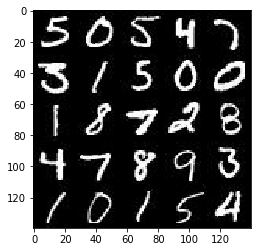

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

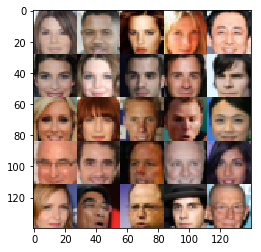

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input")
    z_data = tf.placeholder(tf.float32, [None, z_dim], name="z_data")
    learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")

    return input, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        #input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, keep_prob=0.8)
        #x1 : 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=0.8)
        #x2 : 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=0.8)
        #x3 : 4x4x256
        
        flat = tf.reshape(relu3,(-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1,(-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.nn.dropout(relu1,keep_prob=0.5)
        #7x7x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=0.5)
        #14x14x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=0.5)
        #28x28x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding="same")
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    #generator model
    g_model = generator(input_z, out_channel_dim)
    #discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                        labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    #generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_model_fake)))
    
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #get weights and bias
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                #normalize input
                batch_images *= 2.0
                #random noise
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                #run optimizer
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, 
                                              input_z:batch_z})
                #perform g_opt twice
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images})
                
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images})
                
                if steps % print_every == 0:
                    #print loss
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.4403... Generator Loss: 0.6894
Epoch 1/2... Discriminator Loss: 2.1719... Generator Loss: 1.3681
Epoch 1/2... Discriminator Loss: 1.6566... Generator Loss: 1.3197
Epoch 1/2... Discriminator Loss: 1.6581... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 1.7884... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.7405... Generator Loss: 1.7847
Epoch 1/2... Discriminator Loss: 1.4324... Generator Loss: 1.2892
Epoch 1/2... Discriminator Loss: 1.7177... Generator Loss: 1.6208
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 1.5571


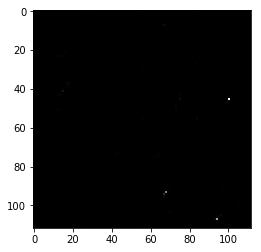

Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 1.1233
Epoch 1/2... Discriminator Loss: 2.0169... Generator Loss: 1.2540
Epoch 1/2... Discriminator Loss: 1.2980... Generator Loss: 0.9697
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 0.9921
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.7982
Epoch 1/2... Discriminator Loss: 1.5153... Generator Loss: 1.3499
Epoch 1/2... Discriminator Loss: 1.5740... Generator Loss: 1.3829
Epoch 1/2... Discriminator Loss: 1.7685... Generator Loss: 0.5483
Epoch 1/2... Discriminator Loss: 1.6421... Generator Loss: 0.4867


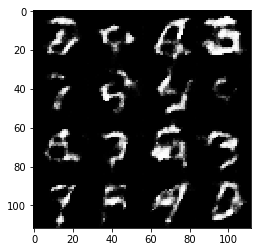

Epoch 1/2... Discriminator Loss: 1.8495... Generator Loss: 0.4234
Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.7222
Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 1.0506
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.9117
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.5997
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 1.0241
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.8257


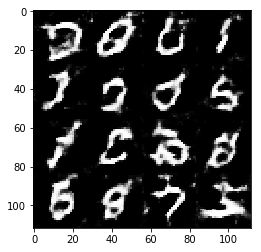

Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.5130
Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 0.6261
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.8208
Epoch 1/2... Discriminator Loss: 1.7709... Generator Loss: 0.3744
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 1.1007
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.9211
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.6520
Epoch 1/2... Discriminator Loss: 1.3629... Generator Loss: 1.3877
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.8234
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 1.1695


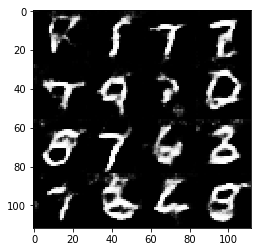

Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.6176
Epoch 1/2... Discriminator Loss: 1.4143... Generator Loss: 1.0673
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.8755
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.5042
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 1.5277
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.4730... Generator Loss: 0.7540


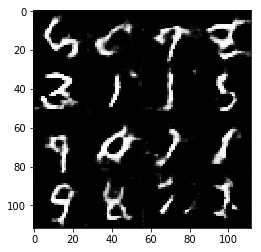

Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 1.1494... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 1.6147... Generator Loss: 0.5236
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.5724
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.9564
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.9438
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.7272
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.8169
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 1.6659


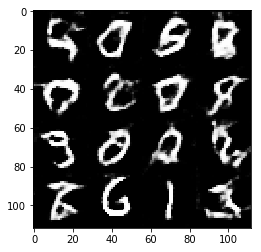

Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 1.2422
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.5719
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 1.0821
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 1.3323
Epoch 1/2... Discriminator Loss: 1.3445... Generator Loss: 1.0700
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.6719


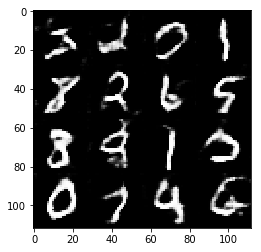

Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 0.7017
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.7735
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 0.8097
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.1188
Epoch 1/2... Discriminator Loss: 1.2887... Generator Loss: 0.7053


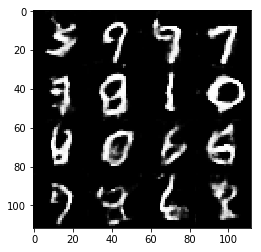

Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 1.0271
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.6213... Generator Loss: 0.4908
Epoch 1/2... Discriminator Loss: 1.4781... Generator Loss: 0.4471
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.6118
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 1.1671
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 1.0097
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.6148
Epoch 1/2... Discriminator Loss: 1.2310... Generator Loss: 0.7416


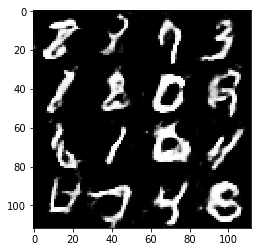

Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.6002
Epoch 1/2... Discriminator Loss: 1.4033... Generator Loss: 1.1307
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.6389
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.5271
Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 1.3808
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.9558
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.6092
Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 1.2385


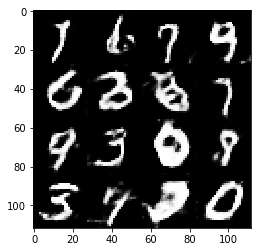

Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 1.1565
Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 1.1717... Generator Loss: 1.1098
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 1.0536
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 1.4130
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 1.3471... Generator Loss: 0.5940
Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 1.2837
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 1.3954


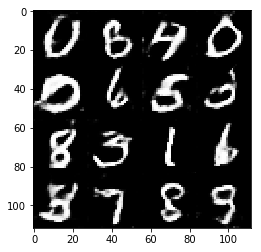

Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 1.4892
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 1.0652
Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 1.1451
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 0.6443
Epoch 1/2... Discriminator Loss: 1.0564... Generator Loss: 0.8895
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.0057
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 1.7000... Generator Loss: 0.4667
Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.4612
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.9778


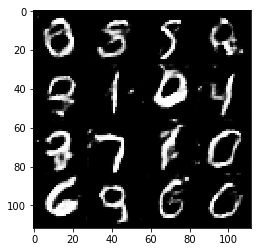

Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.6508
Epoch 1/2... Discriminator Loss: 1.1789... Generator Loss: 1.1296
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 1.0477
Epoch 1/2... Discriminator Loss: 1.0580... Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.3338... Generator Loss: 1.4458
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 1.2007... Generator Loss: 1.1940


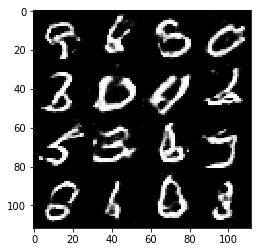

Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 1.0494
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.4995
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 1.1891
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 1.1838
Epoch 1/2... Discriminator Loss: 1.1761... Generator Loss: 1.0284
Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 1.0806
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 1.1817
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 0.7812


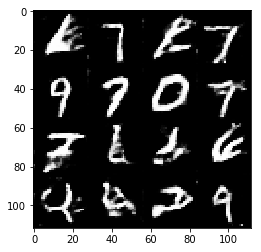

Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7068
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 1.5779
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 1.7601
Epoch 1/2... Discriminator Loss: 0.9706... Generator Loss: 1.7714
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 0.7969


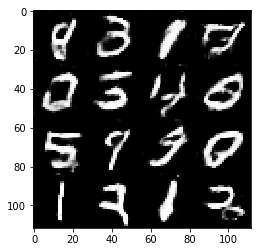

Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 1.0419
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.9689
Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 1.4803
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 1.3643
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.6146
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 1.0598


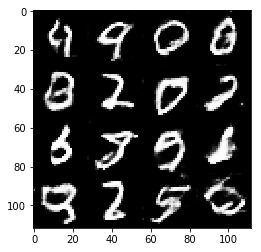

Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 1.5337
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 0.7057
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.8139
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 1.0048
Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 2.1198
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 1.1487
Epoch 1/2... Discriminator Loss: 1.1157... Generator Loss: 1.4128
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 1.0962
Epoch 1/2... Discriminator Loss: 0.9901... Generator Loss: 0.9847


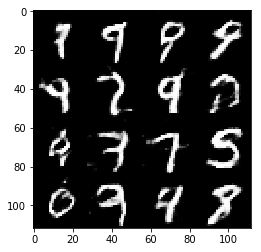

Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 1.0294
Epoch 1/2... Discriminator Loss: 1.0367... Generator Loss: 1.1726
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 1.2591
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 1.6430
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 1.7510
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 1.0535
Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.9118
Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 0.8118


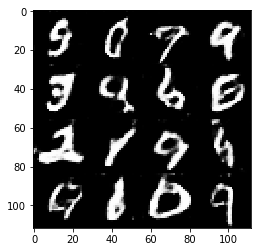

Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 1.1151
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 1.6554
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 1.1408
Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 1.2806
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 1.6407
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 1.0669
Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 1.2706
Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 1.1502


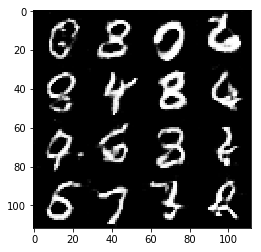

Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 0.9944... Generator Loss: 1.2504
Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 0.9056... Generator Loss: 1.1486
Epoch 2/2... Discriminator Loss: 1.1973... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 1.0834
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.1821
Epoch 2/2... Discriminator Loss: 1.1527... Generator Loss: 1.7322


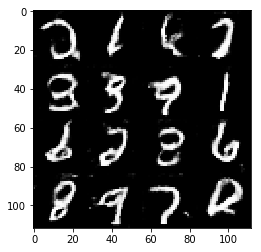

Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 0.9962
Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 0.5234
Epoch 2/2... Discriminator Loss: 1.0732... Generator Loss: 1.0358
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 1.3830
Epoch 2/2... Discriminator Loss: 0.9346... Generator Loss: 1.3217
Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 1.0267... Generator Loss: 0.8682
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.7816
Epoch 2/2... Discriminator Loss: 1.0051... Generator Loss: 1.4210


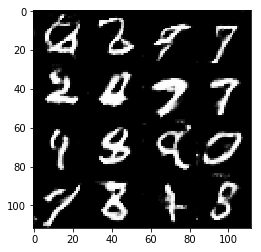

Epoch 2/2... Discriminator Loss: 0.9999... Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 1.5581
Epoch 2/2... Discriminator Loss: 1.0158... Generator Loss: 1.1621
Epoch 2/2... Discriminator Loss: 1.2707... Generator Loss: 1.3795
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 1.5529
Epoch 2/2... Discriminator Loss: 1.0251... Generator Loss: 1.1231
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.6662
Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 0.6307
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 1.2227
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 1.4938


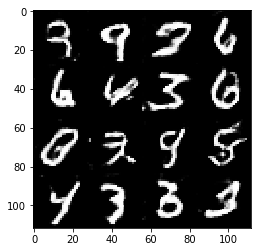

Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 1.1409... Generator Loss: 1.8646
Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 1.4098
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.9240
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 1.2277
Epoch 2/2... Discriminator Loss: 1.5051... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 0.8605
Epoch 2/2... Discriminator Loss: 1.0428... Generator Loss: 1.2013
Epoch 2/2... Discriminator Loss: 1.6049... Generator Loss: 0.6534


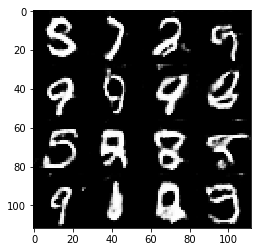

Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 1.6927
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 1.1936
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.8539
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 1.2930
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.6039
Epoch 2/2... Discriminator Loss: 1.0576... Generator Loss: 0.8609
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 1.2050
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 2.3471


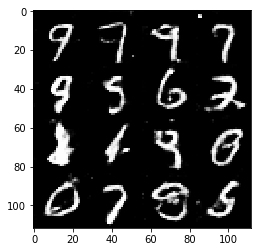

Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 1.3475
Epoch 2/2... Discriminator Loss: 0.9810... Generator Loss: 1.1693
Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 0.6066
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 0.8819
Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 1.1395
Epoch 2/2... Discriminator Loss: 1.1398... Generator Loss: 1.1680
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 1.2365
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 0.9234
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.7798
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 1.7835


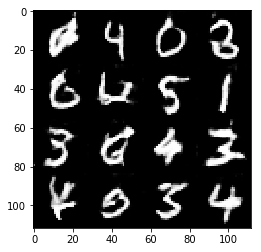

Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 1.3376
Epoch 2/2... Discriminator Loss: 0.9281... Generator Loss: 1.4723
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 1.1970
Epoch 2/2... Discriminator Loss: 0.8061... Generator Loss: 1.3190
Epoch 2/2... Discriminator Loss: 0.7436... Generator Loss: 1.5896
Epoch 2/2... Discriminator Loss: 1.2253... Generator Loss: 2.1238
Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 0.9503
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 1.7249
Epoch 2/2... Discriminator Loss: 1.0462... Generator Loss: 1.5089
Epoch 2/2... Discriminator Loss: 0.8577... Generator Loss: 1.8003


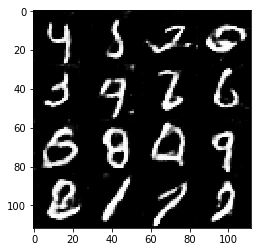

Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 1.9579
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 1.5297
Epoch 2/2... Discriminator Loss: 1.0029... Generator Loss: 1.1714
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.9902
Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 1.3238
Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 1.2081
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.4545
Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 1.3949
Epoch 2/2... Discriminator Loss: 0.7688... Generator Loss: 1.3632


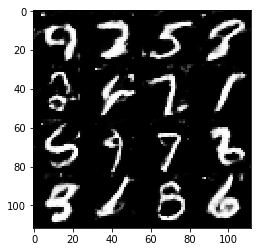

Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.5541
Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.3627
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 1.1975
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 1.8502
Epoch 2/2... Discriminator Loss: 1.1044... Generator Loss: 2.4465
Epoch 2/2... Discriminator Loss: 0.8115... Generator Loss: 1.2012
Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 2.4402
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 2.0394
Epoch 2/2... Discriminator Loss: 0.8330... Generator Loss: 1.4480
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 1.0398


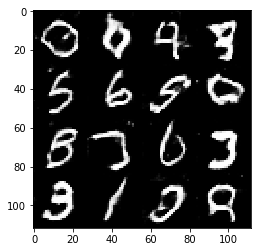

Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 1.7611
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 1.6663
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 1.5741
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 1.3431
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 1.1631
Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 1.1547
Epoch 2/2... Discriminator Loss: 1.2288... Generator Loss: 2.1757
Epoch 2/2... Discriminator Loss: 1.0731... Generator Loss: 1.7485
Epoch 2/2... Discriminator Loss: 1.0477... Generator Loss: 1.2031
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 1.7850


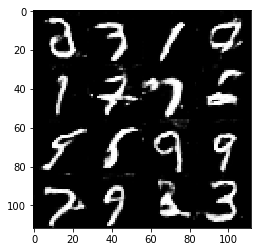

Epoch 2/2... Discriminator Loss: 0.8048... Generator Loss: 1.6772
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 1.6818
Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.2508
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 1.2143
Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 1.9234
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 1.9479
Epoch 2/2... Discriminator Loss: 0.6572... Generator Loss: 1.8891
Epoch 2/2... Discriminator Loss: 1.0636... Generator Loss: 2.0830
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 2.3075
Epoch 2/2... Discriminator Loss: 1.8219... Generator Loss: 0.6419


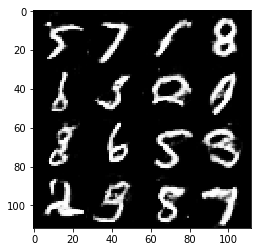

Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 1.3191
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 1.0534
Epoch 2/2... Discriminator Loss: 0.8629... Generator Loss: 1.4796
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 1.6440
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 1.8798
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 1.7393
Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 1.3468
Epoch 2/2... Discriminator Loss: 0.8616... Generator Loss: 1.1561
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.9990


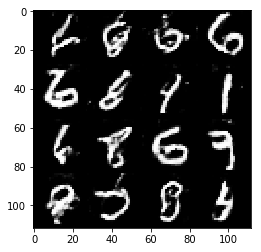

Epoch 2/2... Discriminator Loss: 0.6834... Generator Loss: 1.7292
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.6464
Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 1.8076
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 2.0171
Epoch 2/2... Discriminator Loss: 0.6450... Generator Loss: 1.7505
Epoch 2/2... Discriminator Loss: 0.7060... Generator Loss: 2.5393
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 2.0623
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 1.3324
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 1.2302
Epoch 2/2... Discriminator Loss: 0.8623... Generator Loss: 1.2117


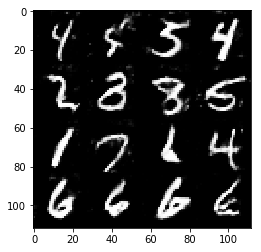

Epoch 2/2... Discriminator Loss: 0.7257... Generator Loss: 1.7983
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 1.2401
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 2.9070
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 1.1852
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 1.7970
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 1.4200
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 1.6771
Epoch 2/2... Discriminator Loss: 1.2172... Generator Loss: 2.9226
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 1.5692


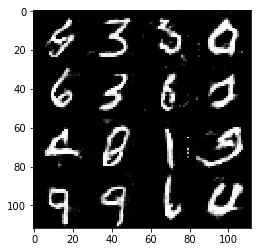

Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 1.4396
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 1.9132
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 2.0075
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.0593
Epoch 2/2... Discriminator Loss: 0.6755... Generator Loss: 2.0109
Epoch 2/2... Discriminator Loss: 0.8466... Generator Loss: 2.4432
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 1.4538
Epoch 2/2... Discriminator Loss: 0.6810... Generator Loss: 1.2737
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 1.4741
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 2.1194


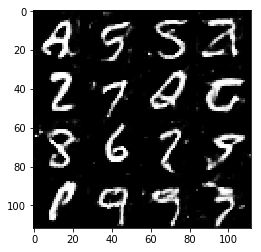

Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 0.6025
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 1.5280
Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 1.4048
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 1.2854
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.9566
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.9896
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 2.1699
Epoch 2/2... Discriminator Loss: 0.7394... Generator Loss: 2.3642
Epoch 2/2... Discriminator Loss: 0.6123... Generator Loss: 2.2974
Epoch 2/2... Discriminator Loss: 1.4184... Generator Loss: 3.4136


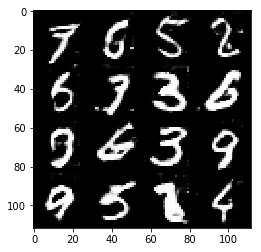

Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 2.3946
Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 2.9236
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 1.8394
Epoch 2/2... Discriminator Loss: 1.0908... Generator Loss: 1.0950
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 1.4480
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.4875
Epoch 2/2... Discriminator Loss: 0.8122... Generator Loss: 2.0605
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 1.1146
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.5919


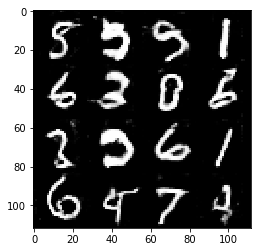

Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.0768
Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 1.7585
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.6654
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 0.9721
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.9969
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 1.4924
Epoch 2/2... Discriminator Loss: 1.1070... Generator Loss: 0.5480
Epoch 2/2... Discriminator Loss: 0.6369... Generator Loss: 1.5080


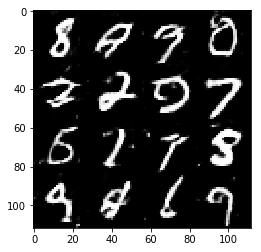

Epoch 2/2... Discriminator Loss: 0.6577... Generator Loss: 1.8988
Epoch 2/2... Discriminator Loss: 0.6027... Generator Loss: 2.3141
Epoch 2/2... Discriminator Loss: 0.6677... Generator Loss: 1.5441
Epoch 2/2... Discriminator Loss: 0.6959... Generator Loss: 1.6501
Epoch 2/2... Discriminator Loss: 0.7172... Generator Loss: 2.0516


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 1.2602
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 2.8312
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 3.3736
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 4.9906
Epoch 1/1... Discriminator Loss: 1.8126... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 2.0917... Generator Loss: 3.2697


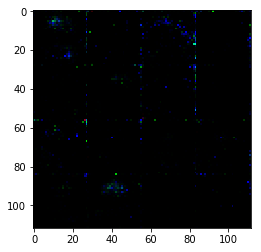

Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.9602
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 2.3970
Epoch 1/1... Discriminator Loss: 1.7958... Generator Loss: 2.7412
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.8513


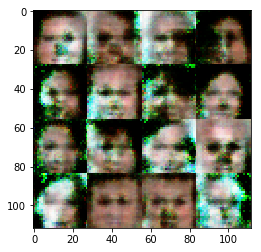

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 1.1192
Epoch 1/1... Discriminator Loss: 1.8714... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 1.2343
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.8706... Generator Loss: 0.4273


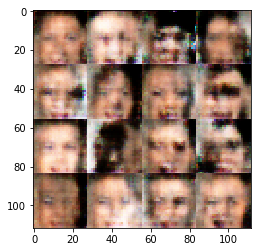

Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 1.6024
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.2213
Epoch 1/1... Discriminator Loss: 1.6972... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.9099


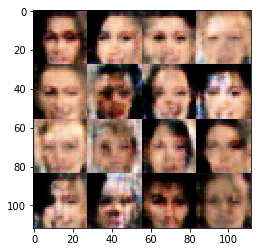

Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 1.3225
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.8282


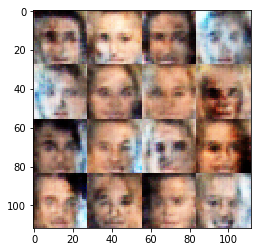

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.7495... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.8325


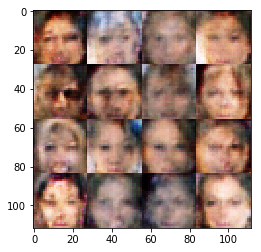

Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.7092


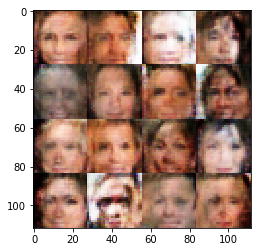

Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6530


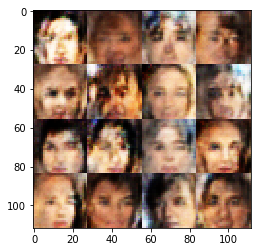

Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.7314


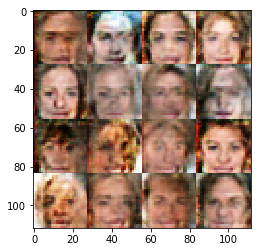

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8295


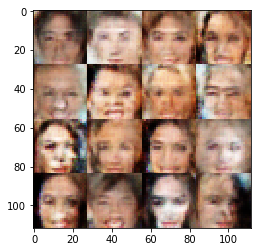

Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.9006


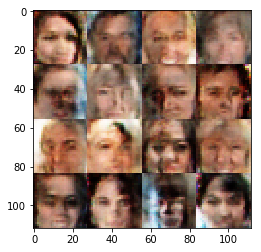

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7428


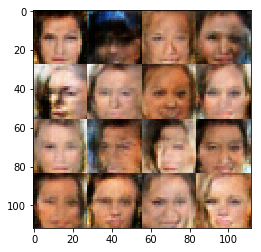

Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6775


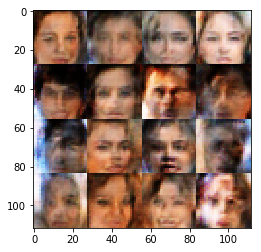

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6397


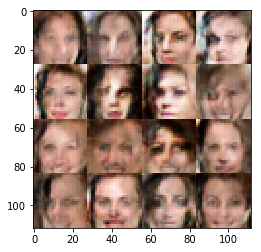

Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8153


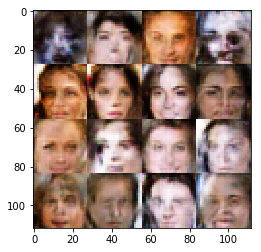

Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.9224


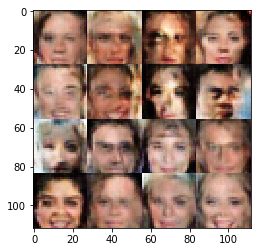

Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.6273... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6660


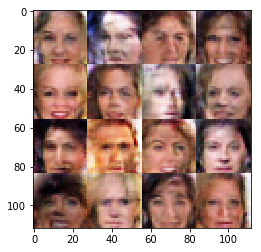

Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6551


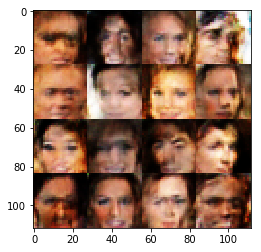

Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.7663


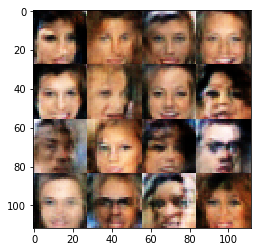

Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.6974


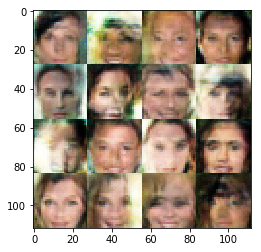

Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.8476


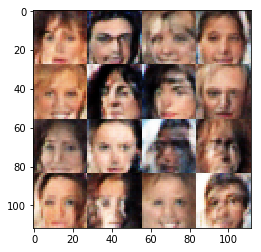

Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6376


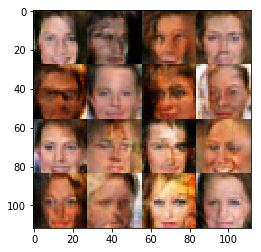

Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7510


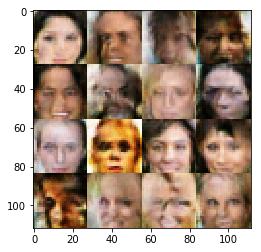

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7354


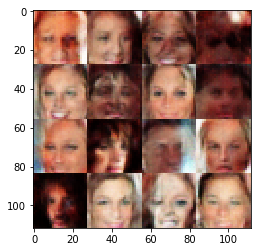

Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7405


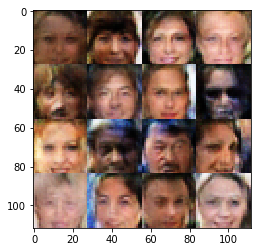

Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6335


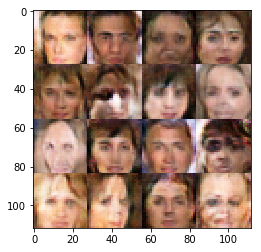

Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6866


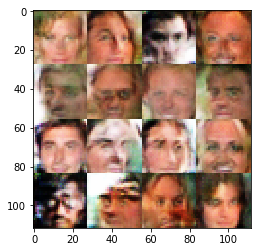

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7870


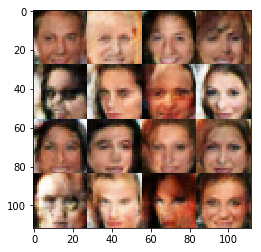

Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 1.0108


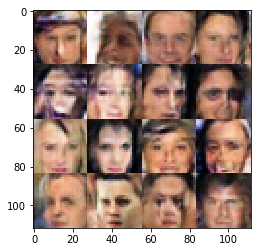

Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8551


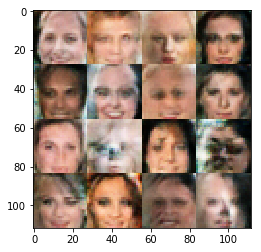

Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.5579


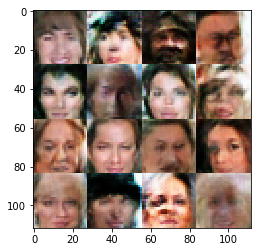

Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7746


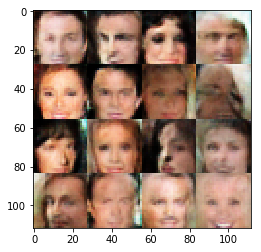

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 0.5099


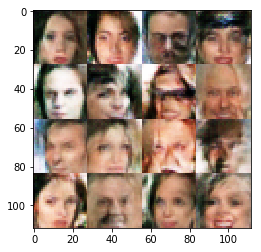

Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7940


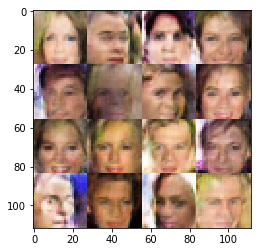

Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6556


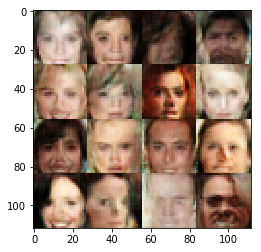

Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.7901


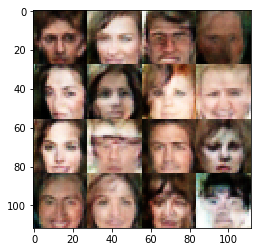

Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.8014


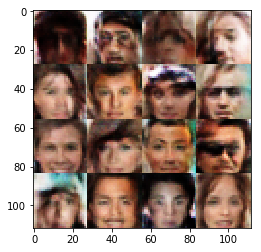

Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7609


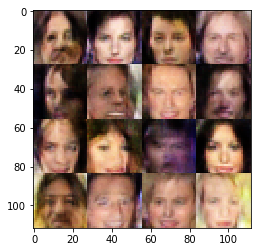

Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.8401


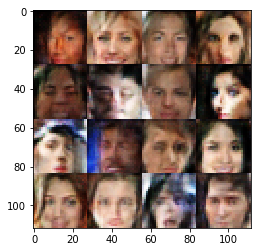

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7041


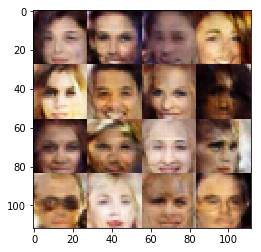

Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.9281


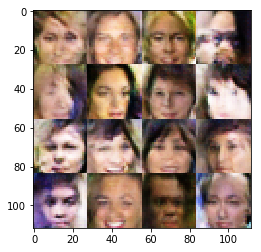

Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6732


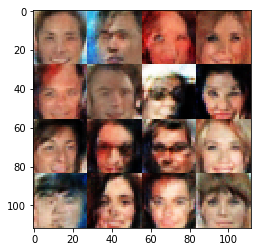

Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.8029


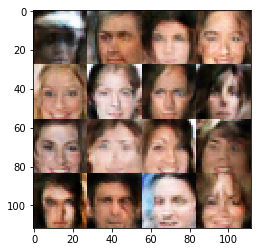

Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.8173


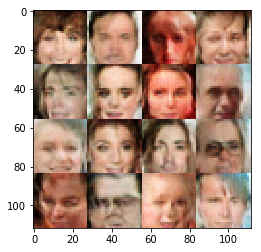

Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6125


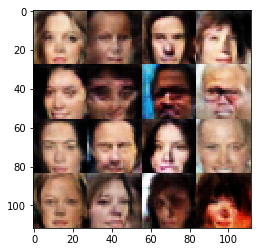

Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7780


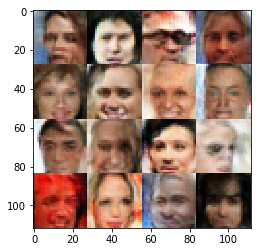

Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 1.3231
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.8540


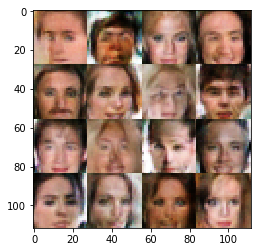

Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 1.2826
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8084


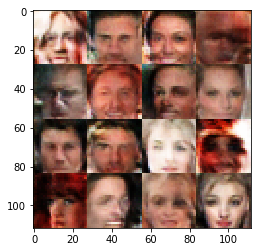

Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.4784


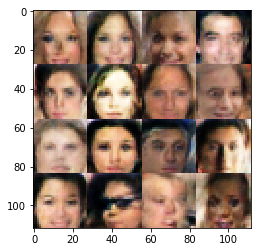

Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.6915


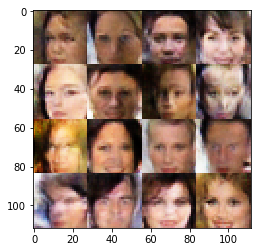

Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.8148


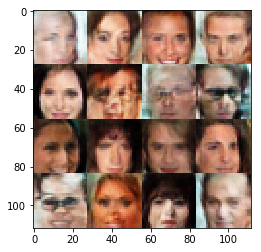

Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.0659


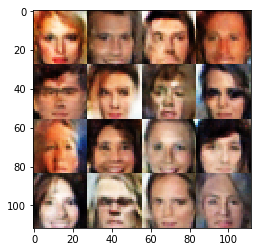

Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 1.0750


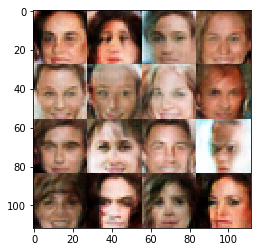

Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.9992


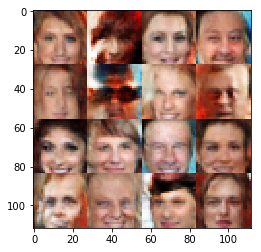

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 1.0090


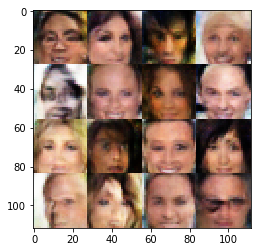

Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.0383


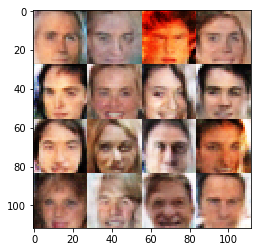

Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 1.4405
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.9667


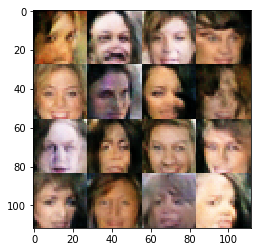

Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 1.3823
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.9177


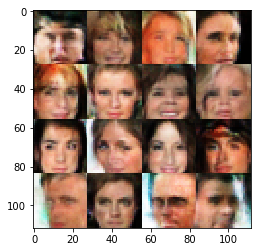

Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 1.0787
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.7422


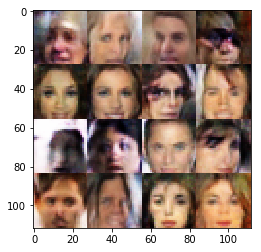

Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8964


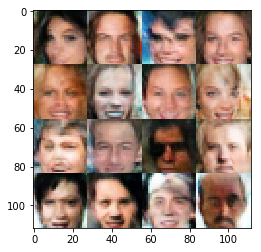

Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.9813


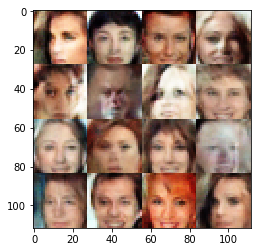

Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.9086


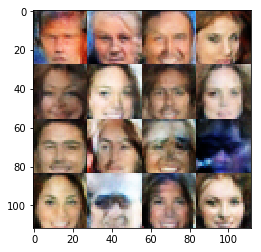

Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.9956


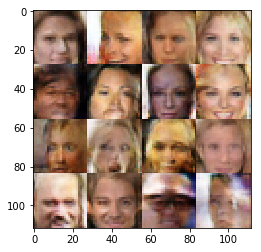

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.9101


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.